<a href="https://colab.research.google.com/github/fabiormazza/IA025_2022S1/blob/main/ex02/fabio_mazza/Aula_2_Exerc%C3%ADcio_using_BCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook de referência 

Nome: Fabio Renato Zocal Mazza

## Instruções

Este exercício consiste em escrever um código para treinar um modelo linear usando SGD e vizualizar como a função de perda varia em função das pesos da rede.

A implementação será considerada correta apenas se passar nos 3 asserts ao longo deste notebook.

## Problema de Regressão Linear

O problema de ajuste de uma reta a um conjunto de pontos para verificar se existe uma previsão linear é um problema muito antigo, muito estudado e muito presente nos dias de hoje. 

Quando o ajuste é abordado como um problema de **otimização numérica**, ele é a base de boa parte dos **conceitos sobre redes neurais** e iremos explorá-lo aqui como uma forma de introdução às redes neurais. O modelo de regressão linear que iremos utilizar pode
ser visto como uma rede neural de apenas uma camada e função de ativação linear.

## Conjunto de dados: Flores Íris

Iremos utilizar duas propriedades do conjunto de dados das flores Íris [Wikipedia-Iris_flower_data_set](https://en.wikipedia.org/wiki/Iris_flower_data_set):

* o comprimento das sépalas e 
* o comprimento da pétalas. 

A ideia será prever o comprimento da pétala, conhecendo-se o comprimento da sépala. Estaremos usando apenas uma propriedade, ou característica ou *feature* do objeto para que seja fácil visualizar o espaço de busca de parâmetros. 

Vamos utilizar as 50 amostras da variedade versicolor.

![](https://raw.githubusercontent.com/robertoalotufo/files/master/figures/iris_petals_sepals.png)

## Dados: leitura e visualização


In [45]:
%matplotlib inline
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython import display

import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
import time

In [46]:
iris = load_iris()
data = iris.data[iris.target==1,::2]  # comprimento das sépalas e pétalas, indices 0 e 2

x_in = data[:,0:1]
y_in = data[:,1:2]
iris_pd = pd.DataFrame(x_in, columns=['x_in'])
iris_pd['y_in'] = y_in
iris_pd.head()

,x_in,y_in
0,7.0,4.7
1,6.4,4.5
2,6.9,4.9
3,5.5,4.0
4,6.5,4.6


## Visualização dos dados `x_in` e `y_in` e normalizados

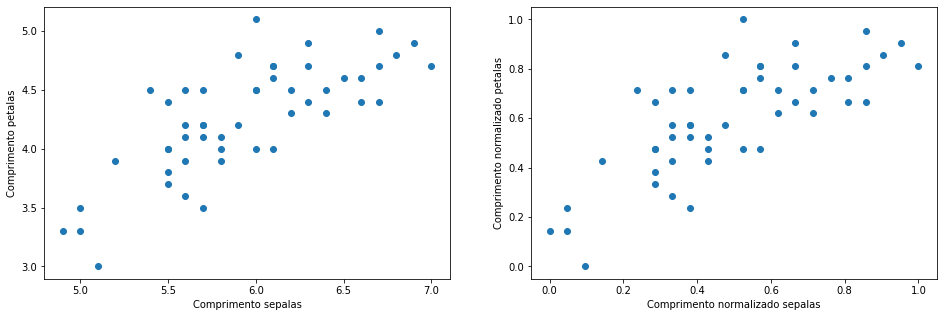

In [47]:
x = x_in - x_in.min()
x /= x.max()    # normalização
y = y_in - y_in.min()
y /= y.max()

fig = plt.figure(figsize=(16,5))
ax_in = fig.add_subplot(1,2,1)
ax_in.scatter(x_in, y_in)
ax_in.set_xlabel('Comprimento sepalas')
ax_in.set_ylabel('Comprimento petalas')
ax_n = fig.add_subplot(1,2,2)
ax_n.scatter(x, y)
ax_n.set_xlabel('Comprimento normalizado sepalas')
ax_n.set_ylabel('Comprimento normalizado petalas');

## Reta de ajuste

A equação da reta no plano necessita de dois parâmetros, aqui denominados $w_0$ (*bias*) e inclinação $w_1$. Veja figura:


<img src="https://raw.githubusercontent.com/robertoalotufo/files/master/figures/linhareta.png" width="300pt">

A reta de ajuste será dada por:

$$ \hat{y} = w_0 + w_1 x $$

onde 
* $w_1$ é o coeficiente angular da reta e 
* $w_0$ é a interseção do eixo vertical quando x é igual a zero, também denominado de *bias*.
* $x$ é a variável de entrada (comprimento das sépalas) e 
* $\hat{y}$ é a predição (comprimento estimado das pétalas).

## Representação gráfica da equação linear via neurônio

$ \hat{y} = 1 w_0 + x_0 w_1 $

Temos:
- 1 atributo de entrada: $x_0$
- 2 parâmetros para serem ajustados (treinados) $w_0$ e $w_1$
- 1 classe de saída $\hat{y}$

<img src="https://raw.githubusercontent.com/robertoalotufo/files/master/figures/RegressaoLinearNeuronio.png" width="300pt">
$$ \hat{y} = w_0 + w_1 x $$
$$ \mathbf{\hat{y}} = \mathbf{w} \mathbf{x} $$

### Função Custo ou de Perda (MSE - Mean Square Error)

<img src="https://raw.githubusercontent.com/robertoalotufo/files/master//figures/Loss_MSE.png" width = "600pt">


A função de custo depende do conjunto de treinamento ($y_i$) e dos valores de predição ($\hat{y_i}$):

$$ J(\hat{y_i},y_i) = \frac{1}{M} \sum_{i=0}^{M-1} (\hat{y_i} - y_i)^2 $$ .


## Laço de minimização via gradiente descendente

O código da próxima célula é a parte principal deste notebook. É aqui que a minimização é feita. É aqui que dizemos que estamos fazendo o *fit*, ou o treinamento do sistema para encontrar o parâmetro $\mathbf{W}$ que minimiza a função de perda $J$. Acompanhamos a convergência da minimização pelo valor da perda a cada iteração, plotando o vetor `J_history`.

O esquema da otimização é representado pelo diagrama a seguir:

<img src="https://raw.githubusercontent.com/robertoalotufo/files/master/figures/RegressaoLinear_Otimizacao.png" width = "600pt">

e é implementado pela próxima célula de código:

## Funções: Custo, Gradiente Descendente

In [48]:
# É importante fixar as seeds para passar nos asserts abaixo.

import random
import numpy as np
import torch
import torch.nn as nn

random.seed(123)
np.random.seed(123)

In [49]:
x = x.astype('float32')
x = torch.from_numpy(x)
x = torch.cat((torch.ones((x.shape[0], 1)), x), 1)

In [50]:
y = y.astype('float32')
y = torch.from_numpy(y)

In [51]:
print(torch.min(x), torch.max(x))
print(torch.min(y), torch.max(y))

tensor(0.) tensor(1.)
tensor(0.) tensor(1.)


In [52]:
class Model():
    def __init__(self, n_in: int, n_out: int):
        # Escreva seu código aqui.
        # Não se esqueça de inicializar os pesos da rede com zeros.
        self.w = torch.zeros((n_in, n_out), requires_grad=True)
    
    def forward(self, x):
        # Escreva seu código aqui.
        y_pred = torch.matmul(x, self.w)

        return y_pred

In [53]:
def train(model, x, y, learning_rate: float, n_epochs: int):
    """Train a linear model with SGD.

    Returns:
        loss_history: a np.array of shape (n_epochs,)
        w_history: a np.array of shape (n_epochs, 2)
    """
    # Escreva seu código aqui.
    loss_history = np.zeros((n_epochs, ))
    w_history = np.zeros((n_epochs, 2))
    loss = nn.BCELoss()

    for e in range(n_epochs):
      y_hat = model.forward(x)
      J = loss(y_hat, y)
      loss_history[e] = J.detach().numpy()
      model.w.retain_grad()
      J.backward()
      grad = model.w.grad
      w_history[e] = model.w.detach().numpy().reshape((1, -1))
      model.w = model.w - learning_rate * grad
      


   
    print(loss_history)
    print(w_history)
    return loss_history, w_history

### Testando as funções

In [54]:
#NOTA: Os testes foram removidos pois foram realizados para números fora do intervalo [0, 1]

# Função de cálculo do grid de custos

In [55]:
def compute_loss_grid(x, y, w_0_grid, w_1_grid):
    """Returns:
        loss_grid: an array with the same shape of w_0_grid (or w_1_grid). 
    """
    # Escreva seu código aqui.
    w_0_grid = w_0_grid.astype('float32')
    w_0_grid = torch.from_numpy(w_0_grid)
    w_1_grid = w_1_grid.astype('float32')
    w_1_grid = torch.from_numpy(w_1_grid)

    w0, w1 = torch.meshgrid(w_0_grid, w_1_grid)
    w0 = w0.reshape(1, -1)
    w1 = w1.reshape(1, -1)
    x = x[:, 1]
    x = x.reshape(x.shape[0], -1)
   
    diffs_2 = ((w0 + torch.matmul(x, w1)) - y) ** 2
    cost_grid = diffs_2.mean(axis = 0)
    cost_grid = cost_grid.reshape(w_0_grid.shape[0], w_1_grid.shape[0])
    
    ## Even though the nomenclature is using "loss" the more appropriate term would be "cost"
    loss_grid = cost_grid.detach().numpy().astype('float64').T


    return loss_grid

In [56]:
wmin = w_history.min(axis=0)
wmax = w_history.max(axis=0)
D = wmax - wmin
wmin -= D
wmax += D

w_0_grid = np.linspace(wmin[0], wmax[0], 100)
w_1_grid = np.linspace(wmin[1], wmax[1], 100)

loss_grid = compute_loss_grid(x, y, w_0_grid, w_1_grid)

### Testando a função

In [57]:
!gsutil cp gs://unicamp-dl/ia025a_2022s1/aula2/target_loss_grid.npy .
target_loss_grid = np.load('target_loss_grid.npy')

Copying gs://unicamp-dl/ia025a_2022s1/aula2/target_loss_grid.npy...
/ [1 files][ 78.2 KiB/ 78.2 KiB]                                                
Operation completed over 1 objects/78.2 KiB.                                     


In [58]:
assert np.allclose(loss_grid, target_loss_grid, atol=1e-6) 

## Funcão de Plot

In [59]:
def show_plots(x, y, w_0_grid, w_1_grid, loss_grid, loss_history, w_history, sleep=0.3):
    n_samples = y.shape[0]
    
    x = x[:, 1].reshape(-1, 1).detach().numpy().astype('float64')
    y = y.reshape(-1, 1).detach().numpy().astype('float64')
    print(x.shape, y.shape, w_0_grid.shape, w_1_grid.shape, loss_grid.shape, loss_history.shape, w_history.shape)
    
    # valor ótimo, solução analítica
    # ------------------------------
    x_bias = np.hstack([np.ones((n_samples, 1)), x])
    w_opt = (np.linalg.inv((x_bias.T).dot(x_bias)).dot(x_bias.T)).dot(y)    
    x_all = np.linspace(x.min(), x.max(), 100).reshape(100, 1)
    x_all_bias = np.hstack([np.ones((100, 1)), x_all])
    result_opt = x_all_bias.dot(w_opt)    # Predição do valor ótimo
    
    
    # Gráficos:
    # --------
    fig = plt.figure(figsize=(18, 6))
    ax_grid = fig.add_subplot(1, 3, 1)    # Grid de losses
    ax_loss = fig.add_subplot(1, 3, 2)    # Função perda

    ax_loss.plot(loss_history)
    ax_loss.set_title('Perda', fontsize=15)
    ax_loss.set_xlabel('epochs', fontsize=10)
    ax_loss.set_ylabel('MSE', fontsize=10)

    ax_grid.pcolormesh(w_0_grid, w_1_grid, loss_grid, cmap=plt.cm.coolwarm)
    ax_grid.contour(w_0_grid, w_1_grid, loss_grid, 20)
    ax_grid.scatter(w_opt[0], w_opt[1], marker='x', c='w')  # Solução analítica.
    ax_grid.set_title('W', fontsize=15)
    ax_grid.set_xlabel('w0', fontsize=10)
    ax_grid.set_ylabel('w1', fontsize=10)

    # Plot dinâmico
    # -------------
    for i, (loss, w) in enumerate(zip(loss_history, w_history)):
        ax_loss.scatter(i, loss)
                            
        ax_grid.scatter(w[0], w[1], c='r', marker='o')
        
        display.display(fig)
        display.clear_output(wait=True)
        time.sleep(sleep)


## Plotagem iterativa do gradiente descendente, reta ajuste, parâmetros, função perda

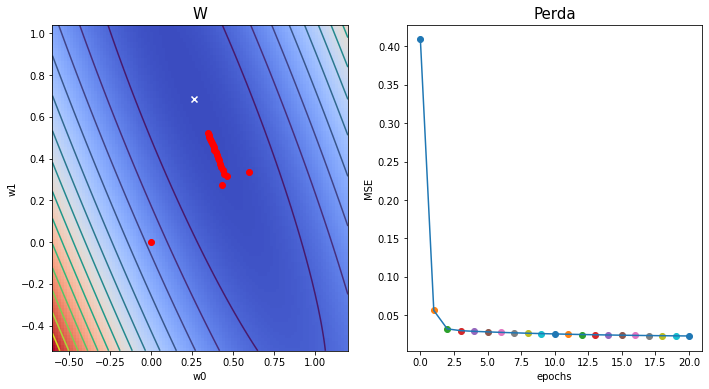

In [60]:
%matplotlib inline
try:
    show_plots(x, y, w_0_grid, w_1_grid, loss_grid, loss_history, w_history, sleep=0.01)
except KeyboardInterrupt:
    pass